In [1]:
import numpy as np
import pandas as pd
import altair as alt
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.datasets import make_regression, load_boston
from sklearn.model_selection import train_test_split, cross_validate, GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.model_selection import check_cv
import duplicate as dp
from functools import partial
import matplotlib.pyplot as plt


# https://altair-viz.github.io/user_guide/display_frontends.html#displaying-in-the-jupyter-notebook
# alt.renderers.enable('mimetype') # works off-line
# alt.renderers.enable('notebook') 
alt.renderers.enable('default') # recommended

RendererRegistry.enable('default')

In [2]:
# get bootstrap.py from parent directory
%cd ..
import bootstrap as bs
import reed as reed
%cd -

/Users/jack/Documents/GitHub/re-education
/Users/jack/Documents/GitHub/re-education/duplication


In [3]:
# X, y = load_boston(return_X_y=True)
X, y = make_regression(n_samples=30_000,n_features=10, n_informative=7, noise=1, random_state=0)

feature_names = [f'X_{i}' for i in range(X.shape[1])]
data = pd.DataFrame(data=X, columns=feature_names)
data['y'] = y
# data.info()

In [4]:
n_duplicates = 4
n_splits = 5
base_groups = np.arange(y.size)
# X_train, X_test, y_train, y_test = train_test_split(X, y,shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.99, shuffle=True)
X_dup, y_dup, weights_dup, groups_dup = dp.simple_duplicate(X_train, y_train, n_duplicates, shuffle=True)

scoring = {
    "MSE": make_scorer(metrics.mean_squared_error),
    "R2": make_scorer(metrics.r2_score),
}


In [5]:
# use custom CV with groups
# model = LinearRegression()
model = reed.StatsmodelsWLS()
# model = GridSearchCV(
#     # LinearRegression(),
#     GradientBoostingRegressor(random_state=0,),
#     # reed.StatsmodelsOLS(),
#     param_grid={},
#     cv=GroupKFold(n_splits=n_splits),
    
    
# )
# model_dup = LinearRegression()
model_dup = reed.StatsmodelsWLS()
# model_dup = GridSearchCV(
#     # LinearRegression(),
#     GradientBoostingRegressor(random_state=0),
#     # reed.StatsmodelsOLS(),
#     param_grid={}, 
#     cv=GroupKFold(n_splits=n_splits)
# )



def mean_var_cv_out(cv_out):
    means_vars = {}
    for k, v in cv_out.items():
        means_vars[k + "_mean"] = np.mean(v)
        means_vars[k + "_var"] = np.var(v)
    return means_vars


# mean_var_cv_out(output), mean_var_cv_out(output_dup)

# Train models, using bootstrapping

In [6]:
# use bootstrapping
def param_extractor(estimator):
    return estimator.get_params()

sample_weight= weights_dup



results = bs.bootstrap(
    estimator=model,
    X=X_train,
    y=y_train,
    error_score="raise",
    # groups=base_groups,
    parameter_extractor=param_extractor,
    return_estimator=True,
    groups=False,
    n_jobs=-1,
#     random_state=
#     sample_weight=sample_weight
)
print("Done un-duplicated")

results_dup = bs.bootstrap(
    estimator=model_dup,
    X=X_dup,
    y=y_dup,
    error_score="raise",
    # groups=groups_dup,
    parameter_extractor=param_extractor,
    return_estimator=True,
    n_jobs=-1,
    groups=False,
    sample_weight=sample_weight
)


# print(results['parameters'])

# print(scores)
# for score_dict in scores:
#     estimator = score_dict["estimator"]

Done un-duplicated


## Evaluate, compare models
Evaluate models on the (unduplicated) test data we set aside.

In [7]:
models = results['estimator']
models_dup = results_dup['estimator']

y_preds, y_preds_dup = ([model.predict(X_test) for model in ms] for ms in (models, models_dup))
y_preds, y_preds_dup = np.array(y_preds), np.array(y_preds_dup)


print(y_preds.shape, y_preds_dup.shape, y_test.shape)

(100, 29700) (100, 29700) (29700,)


In [8]:

scores, scores_dup = (
    [metrics.mean_squared_error(y_pred, y_test) for y_pred in preds] 
    for preds in (y_preds, y_preds_dup)
    )

print(f"mean mse    : {np.mean(scores)}; mse var    : {np.var(scores)}")
print(f"mean dup mse: {np.mean(scores_dup)}; mse var dup: {np.var(scores_dup)}")

mean mse    : 1.068247128988739; mse var    : 0.000576755905876789
mean dup mse: 1.0419534864427582; mse var dup: 9.042090614857754e-05


In [9]:
# choose a representative sample using DBSCAN
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
def find_representative_point_indices(X,y=None, max_num_points=-1, plot=False):
    """
    Get the indices of <max_num_points> representative points (found using DBSCAN algorithm).
    Arbitrarily selects min(max_num_points, num_core_points) core points.
    If max_num_points < 0, select all available core points
    """
    # combine [X, y] if required
    if y is None:
        if len(y.shape) == 1:
            y = y.reshape(-1,1)
        data =  np.hstack([X, y.reshape(-1,1)]) 
    else:
        data = X
    data = RobustScaler().fit_transform(data)
    data_2d = PCA(n_components=2, random_state=0).fit_transform(data)
    
    # cluster
    db = DBSCAN(eps=1).fit(data)
    core_indices = db.core_sample_indices_
    if plot: 
        plt.scatter(data_2d[:,0], data_2d[:,1])
        plt.scatter(data_2d[core_indices, 0], data_2d[core_indices,1], color='red', label="core point")
        plt.xlabel("$C_0$")
        plt.ylabel("$C_1$")
        plt.title("2 principal components")
        plt.legend()

    n_cores = len(core_indices)
    
    if n_cores < max_num_points:
        print(f"There are only {n_cores} representative points; choosing them")
    elif max_num_points > 0:
        core_indices = core_indices[:max_num_points]
    
    return core_indices

In [10]:


# take an arbitrary point in the test set; let's see how its performance changes:
# get represetative point/s from sub-sample if X_test/y_test is huge
# (assumes that test set is shuffled)
n_test_samples = X_test.shape[0]
subset_indices = range(10_000) if n_test_samples > 10_000 else range(n_test_samples)
core_indices = find_representative_point_indices(X_test[subset_indices], y_test[subset_indices], max_num_points=-1, plot=False)#[0]
index=core_indices[0] 
print(f"Chosen index: {index} of {X_test.shape[0]} (based on first {len(subset_indices)} test samples)")



point_y_hat = y_preds[index,:]
point_y_hat_dup = y_preds_dup[index,:]
point_y = y_test[index] * np.ones_like(point_y_hat)
point_data = pd.DataFrame(dict(
    point_y=point_y,
    point_y_hat=point_y_hat,
    point_y_hat_dup=point_y_hat_dup,
))
# print(point_data.describe())



Chosen index: 33 of 29700 (based on first 10000 test samples)


Observe (when the above models are WLS, and there are 4 duplicates used), that the point estimate's bootstrapped uncertainty goes down significantly; in particular, the true $y$ value is ~5 standard deviations away from the mean of the model trained with the duplicated data, up from ~2 stdev away from the mean of the model trained with un-duplicated data.

The uncertainty is increasing de

In [11]:
# Bootstrap parameter uncertainty comparison in linear regressor model

# get the <param_index> parameter of the 2 models
params, params_dup = ([model.coef_ for model in ms] for ms in (models, models_dup))
param_index = 0

param_i, param_i_dup = ([model_params[param_index] for model_params in ps] for ps in (params, params_dup))

print(
    f"param {param_index} mse: {metrics.mean_squared_error(param_i, param_i_dup)}",
    # f"mae: {metrics.mean_absolute_error(param_i, param_i_dup)}",
)



param 0 mse: 0.004543988901674706


Text(0.5, 1.0, 'Duplicate vs unduplicate coefficient 0')

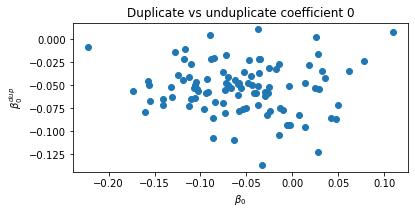

In [12]:
plt.scatter(param_i, param_i_dup)
plt.gca().set_aspect('equal')
plt.xlabel(f"$\\beta_{{{param_index}}}$")
plt.ylabel(f"$\\beta_{{{param_index}}}^{{dup}}$")
plt.title(f"Duplicate vs unduplicate coefficient {param_index}")
# plt.savefig('scatter_param.png')

Let's compare confidience intervals of a pair of WLS models

Text(0.5, 1.0, 'Parameter CIs: duplicate data')

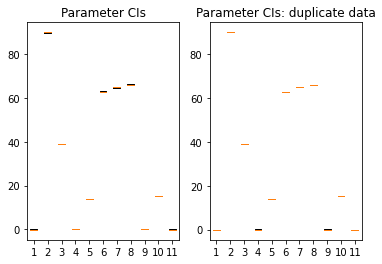

In [13]:
cis, cis_dup = models[0].conf_interval, models_dup[0].conf_interval
# print(ci, ci_dup)
bxpstats, bxpstats_dup = ([{
    "med": (ci[i,0]+ci[i,1])/2,  # TODO fix
    "q1": ci[i,0], # TODO fix
    "q3": ci[i,1], # TODO fix
    "whislo": ci[i, 0], 
    "whishi": ci[i, 1],
    # "fliers"
    } for i in range(len(cis))] for ci in (cis, cis_dup))
fig, ax = plt.subplots(1,2)
ax[0].bxp(bxpstats, showfliers=False)
ax[0].set_title("Parameter CIs")
ax[1].bxp(bxpstats_dup,showfliers=False)
ax[1].set_title("Parameter CIs: duplicate data")



- we see ~~slightly more accurate (?)~~ estimates with substantially less variance in the errors and bootstrapped confidence intervals when using the duplicated data.
- TODO: (after introducing econml model example so as to not prematurely harden the code?): wrap this up into a function that we can pass a model into.
- TODO: see how these properties scale with # duplicates; might yield insight into the cause
- TODO: I'm comparing models trained with different bootstrapped samples (e.g. duplicated/unduplicated) -- this is noisy. I should only compare e.g. statistics over the bootstraps

## Let's try GLS

In [14]:

# attempt to construct residual covariance matrix
n = len(X_dup)

#res_cov[i][j]==1 where X_train[i]==X_train[j], 0 otherwise
res_cov = np.identity(n)#np.array([[groups_dup[i]==groups_dup[j] for j in range(n)] for i in range(n)], dtype=np.float64)
# res_cov = np.maximum(res_cov, 0.01)
print(res_cov)
# print(res_cov.shape)
# print(res_cov)
model, model_dup = reed.StatsmodelsGLS(), reed.StatsmodelsGLS()
model.fit(X_train, y_train)#, sample_weight=np.ones(n))
print("done undup")
model_dup.fit(X_dup, y_dup, sample_weight=res_cov)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
done undup


StatsmodelsGLS()

## Scaling with number of duplicates

Here I'm trying to get a sense of how things scale with the number of duplicates. In particular:
- the boostrapped variance of a point estimate

In [15]:
from sklearn.base import clone

grad_boost = GridSearchCV(
    # LinearRegression(),
    GradientBoostingRegressor(random_state=0),
    # reed.StatsmodelsOLS(),
    param_grid={}, 
    cv=GroupKFold(n_splits=n_splits)
)

In [16]:
# Monkey patch models to include groups argument to .fit()

In [24]:
model_types = {
    "linear": LinearRegression(), 
    "lasso" : Lasso(), 
    "gb" : grad_boost
}
model_groups_param = [False, False, True] # some models need a group parameter
n_duplicates = [1,2,4,8,16,32]

point_index = index
X_test_point = X_test[point_index, :].reshape(1,-1) # 1 sample/1 row
print(X_test_point.shape)
point_y=y_test[index] * np.ones(100) # 100 bootstraps: TODO remove hard-coded constant

point_data = pd.DataFrame(dict(
        point_y=point_y
    ))

results = []

for model_name, groups_ in zip(model_types.keys(), model_groups_param):
    print(f"{model_name}")
    print("------------------")
    results_n_dup = []
    y_preds_n_dup = []
    
    # train, evaluate using duplicate data
    for n in n_duplicates:
        model_dup = clone(model_types[model_name])
        
        X_dup, y_dup, weights_dup, groups_dup = dp.simple_duplicate(X_train, y_train, n, shuffle=True)
    #     print(index)
    #     model_dup  = model_dup.copy()
        results_dup = bs.bootstrap(
            estimator=model_dup,
            X=X_dup,
            y=y_dup,
            error_score="raise",
            # groups=groups_dup,
            parameter_extractor=param_extractor,
            return_estimator=True,
            n_jobs=-1,
            groups=groups_,
            sample_weight=weights_dup
        )
        results_n_dup.append(results_dup)
        # predict based on X_test
        estimator_dup  = results_dup['estimator']
        y_preds_dup = np.array([model.predict(X_test) for model in estimator_dup])
        y_preds_n_dup.append(y_preds_dup)
#         print(y_preds_dup.shape)

        # evaluate using X_test
        scores_dup = [metrics.mean_squared_error(y_test, y_pred) for y_pred  in y_preds_dup]
        mean_mse_dup = np.mean(scores_dup)
        var_mse_dup  = np.var(scores_dup)

        # get all predictions of the <index>th point in 
        point_data[f"dup_point_y_hat_{model_name}_{n}"] = pd.Series(y_preds_dup[:, index])
        print(f"Mean of bootstrapped MSE for {n} duplicates: {mean_mse_dup}")
        print(f"bootstrapped variance of MSE for {n} duplicates: {var_mse_dup}")
        print(f"done with {n} duplicates")


(1, 10)
linear
------------------
Mean of bootstrapped MSE for 1 duplicates: 1.0680763070880537
bootstrapped variance of MSE for 1 duplicates: 0.000612614404773915
done with 1 duplicates
Mean of bootstrapped MSE for 2 duplicates: 1.0508706072010685
bootstrapped variance of MSE for 2 duplicates: 0.0002417582222612508
done with 2 duplicates
Mean of bootstrapped MSE for 4 duplicates: 1.0422212995542701
bootstrapped variance of MSE for 4 duplicates: 9.178778066828066e-05
done with 4 duplicates
Mean of bootstrapped MSE for 8 duplicates: 1.0380784071465374
bootstrapped variance of MSE for 8 duplicates: 3.667304770296822e-05
done with 8 duplicates
Mean of bootstrapped MSE for 16 duplicates: 1.0353202271295094
bootstrapped variance of MSE for 16 duplicates: 2.751388415864872e-05
done with 16 duplicates
Mean of bootstrapped MSE for 32 duplicates: 1.0342895966312118
bootstrapped variance of MSE for 32 duplicates: 1.0942028471384672e-05
done with 32 duplicates
lasso
------------------
Mean of boo

In [25]:
# print(point_data.describe())





In [26]:
#TODO extract point estimates outside the loop

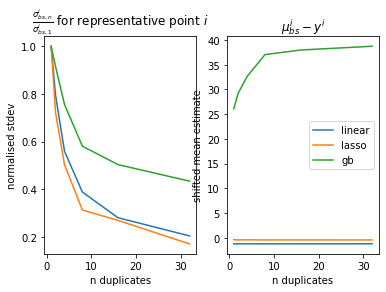

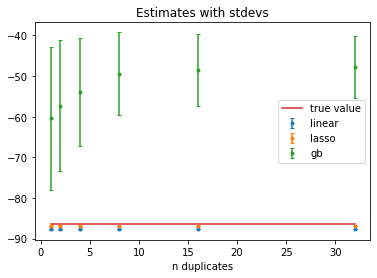

In [27]:
stdevs = point_data.std()
means = point_data.mean()
# print(stdevs)
fig, ax = plt.subplots(1,2)
fig2, ax2 = plt.subplots(1,1)

true_point_value = means["point_y"]

for model_name in model_types.keys():#["LinearRegression()"]:
#     print(f"dup_point_y_hat_{model_name}_1")
    stdev_1 = stdevs[f"dup_point_y_hat_{model_name}_1"] # stdev of model trained with no duplicates
    stdevs_dups = stdevs.filter(regex=f"dup.*{model_name}.*") # stdevs of models trained with duplicates

    # normalise by stdev at n=1 
    normalised_stdevs_mt = stdevs_dups / stdev_1
    
#     print(stdevs_dups)
    ax[0].plot(n_duplicates, normalised_stdevs_mt, label=model_name)
    
    means_dups = means.filter(regex=f"dup.*{model_name}.*")
    normalised_means_dups = means_dups - true_point_value
    ax[1].plot(n_duplicates, normalised_means_dups, label=model_name)
    
    ax2.errorbar(n_duplicates, means_dups, yerr=stdevs_dups, fmt='.', capsize=2, label=model_name)
        
# ax[0].legend()
ax[0].set_xlabel("n duplicates")
ax[0].set_ylabel("normalised stdev")
ax[0].set_title("$\\frac{{\sigma_{{bs,n}}^i}}{{\sigma_{{bs,1}}^i}}$ for representative point $i$")
ax[1].legend()
ax[1].set_xlabel("n duplicates")
ax[1].set_ylabel("shifted mean estimate")
ax[1].set_title("$\\mu_{{bs}}^i - y^i$")


# plot reference value
ax2.plot(n_duplicates, true_point_value*np.ones(len(n_duplicates)), label="true value")
# ax2.set_yscale("log")
ax2.set_title("Estimates with stdevs")
ax2.set_xlabel("n duplicates")
ax2.legend()
# ax[1].set_yscale("log")

In [28]:
# TODO: something is wrong; point_y_hat_4 should be statistically similar to point_y_hat_dup... what's with the stdev??

# Visualise data

In [29]:
chart = alt.Chart(data).mark_point().encode(
    x='X_0',
    y='y',
    color='X_1:Q'
).properties(
    width=200,
    height=200
)

# un-comment to view
# chart

In [30]:
correlations = data.corr().stack().reset_index().rename(columns={0: 'correlation', 'level_0': 'variable 0', 'level_1': 'variable 1'})
# print(correlations.head())
corr_mat = alt.Chart(correlations).mark_rect().encode(
    x='variable 0:N',
    y='variable 1:N',
    color='correlation:Q'
).properties(
    width=200,
    height=200
)

combined_fig = alt.concat(
chart,
corr_mat
).resolve_scale(
    color='independent'
)

# un-comment to view
# combined_fig